In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import csv
import seaborn as sns
plt.style.use('fivethirtyeight')
import numpy as np
import datetime
import re
import time

ImportError: No module named seaborn

In [37]:
task_start_pattern = r"\[(.*)\] Started task: (.*) on worker: (.*)"
task_end_pattern = r"\[(.*)\] Completed task: (.*) on worker: (.*)"

job_start_pattern = r"\[(.*)\] Started job: (.*)"
job_end_pattern = r"\[(.*)\] Completed job: (.*)"

filenames = ["log_file_LL.txt"]

In [38]:
for filename in filenames:

    jobs = dict()
    tasks = dict()
    task_workers = dict()
    num_of_tasks = dict()

    with open(filename, "r") as f:
        lines = f.readlines()
        lines.sort()
        for line in lines:
            # Process job start times
            job_start = re.match(job_start_pattern, line)
            if job_start:
                timestamp, job_id = job_start.groups()
                jobs[job_id] = timestamp

            # Process job end times and compute duration
            job_end = re.match(job_end_pattern, line)
            if job_end:
                end, job_id = job_end.groups()
                start = jobs[job_id]

                startTime = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S.%f")

                endTime = datetime.datetime.strptime(end, "%Y-%m-%d %H:%M:%S.%f")

                duration = endTime - startTime

                elapsed = (duration.days * 86400) + (duration.seconds * 1) + float(duration.microseconds / 1000)/1000

                jobs[job_id] = float(elapsed)

            # Process task start times
            task_start = re.match(task_start_pattern, line)
            if task_start:
                timestamp, task_id, worker_id = task_start.groups()
                tasks[task_id] = timestamp
                if worker_id in task_workers:
                    task_workers[worker_id].append(task_id)
                    t = datetime.datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S.%f")
                    num_of_tasks[worker_id].append((t, 1))
                else:
                    task_workers[worker_id] = [task_id]
                    t = datetime.datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S.%f")
                    num_of_tasks[worker_id] = [(t, 1)]



            # Process task end times and compute duration
            task_end = re.match(task_end_pattern, line)
            if task_end:
                end, task_id, worker_id = task_end.groups()
                start = tasks[task_id]

                startTime = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S.%f")
                endTime = datetime.datetime.strptime(end, "%Y-%m-%d %H:%M:%S.%f")

                duration = endTime - startTime

                elapsed = (duration.days * 86400) + (duration.seconds * 1) + float(duration.microseconds / 1000)/1000

                tasks[task_id] = float(elapsed)
                
                task_workers[worker_id].remove(task_id)
                t = datetime.datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S.%f")
                num_of_tasks[worker_id].append((t, -1))


    jobs_df = pd.DataFrame(jobs.values(), columns=["jobs"])
    tasks_df = pd.DataFrame(tasks.values(), columns=["tasks"])

    mean_jobs = jobs_df["jobs"].mean()
    mean_tasks = tasks_df["tasks"].mean()

    median_jobs = jobs_df["jobs"].median()
    median_tasks = tasks_df["tasks"].median()
    
    algo = filename.split("_")[-1]
    algo = algo.split(".")[0]
    print("Algorithm = {algo}".format(algo=algo))
    print("Job: Mean = {mean}, Median = {median}".format(mean=mean_jobs, median=median_jobs))
    print("Task: Mean = {mean}, Median = {median}\n".format(mean=mean_tasks, median=median_tasks))
    
#     for key in num_of_tasks:
#         print(key, num_of_tasks[key])
#     print("\n")

Algorithm = LL
Job: Mean = 5.037, Median = 5.037
Task: Mean = 2.142875, Median = 2.033



In [77]:
def convert(t1, t2):
    duration = t1 - t2
    elapsed = float((duration.days * 86400000 * 1000) + (duration.seconds * 1000 * 1000) + (duration.microseconds))
    return elapsed

In [32]:
# Graph for worker, Y-axis num tasks, X-axis is timestamp
time_range = dict()
tasks_time_range = dict()
for worker_id in num_of_tasks:
    worker = num_of_tasks[worker_id]
    time_range[worker_id] = [convert_to_sec(worker[i+1][0], worker[i][0]) for i in range(len(worker) - 1)]
    tasks_time_range[worker_id] = [worker[i][1] for i in range(len(worker) - 1)]

In [78]:
time_stamps = dict()
task_counts = dict()

for worker_id in num_of_tasks:
    worker = num_of_tasks[worker_id]
    time_stamps[worker_id] = [i[0] for i in worker]
    task_counts[worker_id] = [i[1] for i in worker]
    task_counts[worker_id] = [sum(task_counts[worker_id][:i]) for i in range(1, len(task_counts[worker_id])+1)]

In [79]:
task_counts

{'1': [1, 2, 1, 2, 1, 0], '2': [1, 2, 3, 2, 3, 2, 1, 0, 1, 0]}

In [80]:
task_counts

{'1': [1, 2, 1, 2, 1, 0], '2': [1, 2, 3, 2, 3, 2, 1, 0, 1, 0]}

In [81]:
base_match = re.match(job_start_pattern, lines[0])
base = 0
if base_match:
    base, _ = base_match.groups()
    base = datetime.datetime.strptime(base, "%Y-%m-%d %H:%M:%S.%f")
for worker_id in num_of_tasks:
    time_stamps[worker_id] = [convert(i, base) for i in time_stamps[worker_id]]

In [82]:
time_stamps

{'1': [343595.0, 343955.0, 343955.0, 2019205.0, 2019205.0, 2019205.0],
 '2': [253.0,
  343394.0,
  343774.0,
  343955.0,
  2018962.0,
  2019205.0,
  2019205.0,
  2019205.0,
  4348353.0,
  4348353.0]}

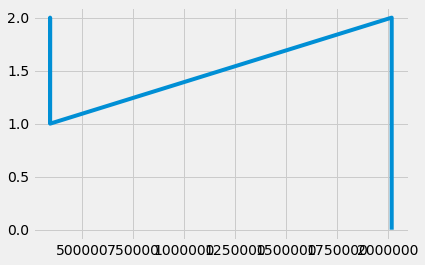

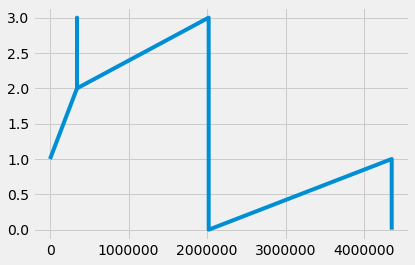

In [83]:
for worker_id in num_of_tasks:
    plt.plot(time_stamps[worker_id], task_counts[worker_id])
    plt.show()